Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# Demo 7 - Geospatial Data

- Coordinate systems
- Points from XY
- Loading shapefiles and geojsons
- Proximity analysis
    - Measuring distance
    - Buffering
- Overlay analysis
- Spatial joining

## Geospatial data fundamentals
- Basic geometry types:
    - Points
    - Linestrings
    - Polygons

<img alt="points, lines, and polygons" width=500 src="https://datacarpentry.org/organization-geospatial/fig/dc-spatial-vector/pnt_line_poly.png">

- Spatial analysis (with vector data) is essentially just Euclidean geometry (remember the Pythagorean theorem?)

<img alt="pythagorean theorem" width=500 src="https://www.katesmathlessons.com/uploads/1/6/1/0/1610286/published/how-to-use-the-pythagorean-theorem-to-find-distance-between-points-on-coordinate-plane-2.png?1595954050">

## Geospatial data are everywhere

DC affordable housing: https://opendata.dc.gov/datasets/DCGIS::affordable-housing/about

In [ ]:
# Install Geopandas

# ! conda install -y geopandas

In [1]:
# Import dependencies
import pandas as pd
import geopandas as gpd

## Make points from CSV

In [2]:
df = pd.read_csv('affordable_housing.csv')

In [8]:
points = gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE'])

In [10]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=points,
    crs=4326,
)

<Axes: >

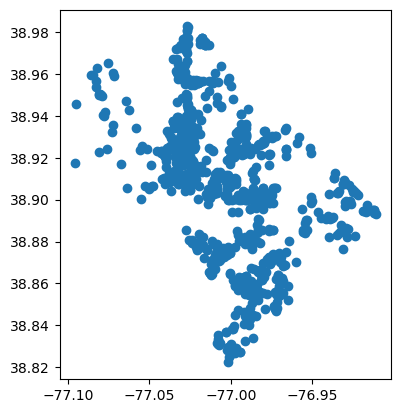

In [11]:
gdf.plot()

## Measuring proximity

### How far is each affordable housing project from Metro Center?
- Map projections

In [12]:
# Let's start by reloading the data with more descriptive variable names so we don't get confused
projects_df = pd.read_csv('Affordable_Housing.csv')
projects_gdf = gpd.GeoDataFrame(projects_df, geometry=gpd.points_from_xy(projects_df['LONGITUDE'], projects_df['LATITUDE']), crs=4326)

In [14]:
metro_center_lon = -77.0312124
metro_center_lat = 38.898202
metro_center_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([metro_center_lon], [metro_center_lat]), crs=4326)

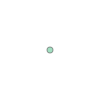

In [18]:
metro_center_gdf['geometry'].iloc[0]

In [20]:
# What's wrong here?
projects_gdf.distance(metro_center_gdf.geometry.iloc[0])

/var/folders/cp/34sfrw4102x64df08gn6pccm0000gq/T/ipykernel_39473/1150215707.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  projects_gdf.distance(metro_center_gdf.geometry.iloc[0])


0      0.024934
1      0.023269
2      0.064320
3      0.083922
4      0.069172
         ...   
873    0.057469
874    0.099904
875    0.044756
876    0.020832
877    0.018455
Length: 878, dtype: float64

## UTM Zones

[Universal Transverse Mercator](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) Zones

The UTM system divides the globe into 120 zones, 60 each in the northern and southern hemispheres. It uses Transverse Mercator projections to minimize shape and distance distortion for localized measurements within each zone.

<img alt="utm slices" width=500 src="https://gisgeography.com/wp-content/uploads/2016/05/UTM-Zones-Globe-2.png">

<img alt="utm standard line" width=500 src="https://gisgeography.com/wp-content/uploads/2016/05/Universe-Transverse-Mercator-Cylinder.png">

1. [What UTM zone am I in?](https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#)
2. [What is the EPSG code for that zone?](https://www.google.com/search?q=epsg+code+for+UTM18N&rlz=1C5GCCM_en&oq=epsg+code+for+UTM18N&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIHCAEQIRigATIHCAIQIRigATIHCAMQIRigATIHCAQQIRigATIHCAUQIRigATIHCAYQIRiPAjIHCAcQIRiPAtIBCDcxMDJqMGo3qAIAsAIA&sourceid=chrome&ie=UTF-8)

In [22]:
# Reproject into the local UTM zone
utm18n = 32618

projects_gdf = projects_gdf.to_crs(utm18n)
metro_center_gdf = metro_center_gdf.to_crs(utm18n)

# ! Calculate distance between each project and metro center

In [23]:
projects_gdf.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
projects_gdf.head(1)

,X,Y,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,...,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,MAR_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry
0,-77.009383,38.910255,89281,Ward 6,"1520 North Capitol Street Northwest, Washingto...",Cycle House,Under Construction,DMPED DHCD,18,38.910248,...,12,0,0,NaN,331764,399186.36,138042.91,1520 NORTH CAPITOL STREET NW,2024/02/05 05:00:27+00,POINT (325776.94 4308736.049)


In [29]:
projects_gdf['meters_from_metro_center'] = projects_gdf.distance(metro_center_gdf.geometry.iloc[0])

In [31]:
# projects_gdf.head()

<Axes: >

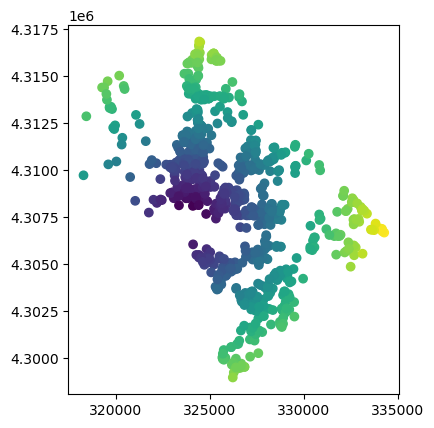

In [33]:
projects_gdf.plot(column='meters_from_metro_center')

In [59]:
len(projects_gdf[projects_gdf.meters_from_metro_center <= 1609])

39

In [36]:
# projects_gdf.explore(column='meters_from_metro_center', tiles='CartoDB positron')

### Which projects are within 1 mile of Metro Center or Columbia Heights?

#### Another approach: Buffer and spatial join

In [43]:
# Define multiple locations
metro_locations = {
    'Metro Center': {
        'lon': -77.0312124, 
        'lat': 38.898202
    },
    'Columbia Heights': {
        'lon': -77.0350154, 
        'lat': 38.92890
    },
    'Union Station': {
        'lon': -77.0089958, 
        'lat': 38.8984109
    }
}

# Convert to a geodataframe
metro_locations_df = pd.DataFrame.from_dict(metro_locations, orient='index')
metro_locations_points = gpd.points_from_xy(metro_locations_df['lon'], metro_locations_df['lat'])
metro_locations_gdf = gpd.GeoDataFrame(metro_locations_df, geometry=metro_locations_points, crs=4326)
metro_locations_gdf = metro_locations_gdf.to_crs(utm18n)

In [47]:
# Buffer metro locations

def miles_to_meters(miles):
    return miles * 1609.34

threshold_dist = miles_to_meters(1) # one mile
metro_locations_buffer = metro_locations_gdf.buffer(threshold_dist)

In [48]:
metro_locations_buffer.explore(tiles='CartoDB positron')

In [49]:
metro_locations_buffer_gdf = gpd.GeoDataFrame(geometry=metro_locations_buffer)
metro_locations_buffer_gdf

,geometry
Metro Center,"POLYGON ((325463.46 4307441.122, 325455.711 43..."
Columbia Heights,"POLYGON ((325209.679 4310855.471, 325201.93 43..."
Union Station,"POLYGON ((327390.754 4307421.63, 327383.005 43..."


In [50]:
projects_near_metro = gpd.sjoin(projects_gdf, metro_locations_buffer_gdf)

In [56]:
# projects_near_metro.head()

In [54]:
projects_near_metro = projects_near_metro.rename(columns={'index_right':'near_metro'})

In [55]:
projects_near_metro['near_metro'].value_counts()

near_metro
Columbia Heights    130
Union Station        82
Metro Center         39
Name: count, dtype: int64

In [ ]:
projects_near_metro.explore(column='near_metro', tiles='CartoDB positron')

## Overlay

### How many projects are in each census tract?

- [Population by Tract from Census Reporter](https://censusreporter.org/data/table/?table=B01003&geo_ids=16000US1150000,140|16000US1150000&primary_geo_id=16000US1150000)

In [63]:
# Load tract polygons from geojson
tracts_gdf = gpd.read_file('acs2023_5yr_B01003_14000US11001007409.geojson')

In [64]:
# Project into local UTM
tracts_gdf = tracts_gdf.to_crs(utm18n)
# Only keep records that are tracts (there's pesky one for all of Washington DC)
tracts_gdf = tracts_gdf[tracts_gdf.geoid.str.len() == 18]

<Axes: >

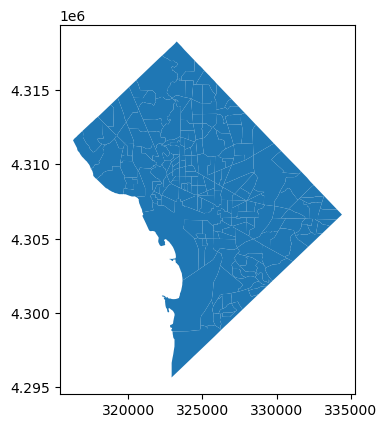

In [65]:
tracts_gdf.plot()

In [68]:
# Ensure projects and tracts are in the same projection (CRS: coordinate reference system)
assert projects_gdf.crs == tracts_gdf.crs

In [69]:
# Spatially join projects to tracts
tracts_with_projects_gdf = gpd.sjoin(tracts_gdf, projects_gdf, how='left')

In [73]:
# tracts_with_projects_gdf.head()

In [74]:
# Count unique projects in each tract
project_counts = tracts_with_projects_gdf.groupby('geoid').index_right.nunique()

project_counts

geoid
14000US11001000101     0
14000US11001000102     1
14000US11001000201     0
14000US11001000202     1
14000US11001000300     0
                      ..
14000US11001010900     0
14000US11001011001     2
14000US11001011002     1
14000US11001011100    12
14000US11001980000     0
Name: index_right, Length: 206, dtype: int64

In [76]:
# Join counts onto tracts
# tracts_with_counts_gdf = tracts_gdf.merge(project_counts, left_on='geoid', right_index=True)
tracts_with_counts_gdf = pd.merge(tracts_gdf, project_counts, left_on='geoid', right_index=True)

<Axes: >

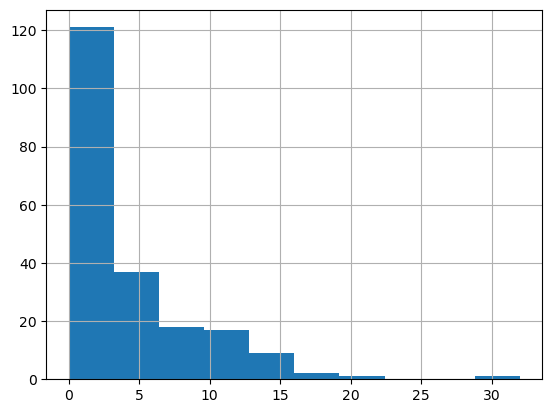

In [79]:
tracts_with_counts_gdf.index_right.hist()

In [80]:
# Cleanup columns
columns = {
    'geoid':'geoid',
    'B01003001':'population',
    'index_right':'projects',
    'geometry':'geometry'
}
tracts_with_counts_gdf = tracts_with_counts_gdf[columns.keys()].rename(columns=columns)

In [81]:
tracts_with_counts_gdf.head()

,geoid,population,projects,geometry
0,14000US11001000101,1181.0,0,"MULTIPOLYGON (((321636.384 4308861.291, 321646..."
1,14000US11001000102,3056.0,1,"MULTIPOLYGON (((320559.557 4307779.46, 320608...."
2,14000US11001000201,2835.0,0,"MULTIPOLYGON (((319723.182 4309141.763, 319744..."
3,14000US11001000202,3964.0,1,"MULTIPOLYGON (((319648.174 4308298.994, 319649..."
4,14000US11001000300,5669.0,0,"MULTIPOLYGON (((319453.518 4310093.782, 319459..."


<Axes: >

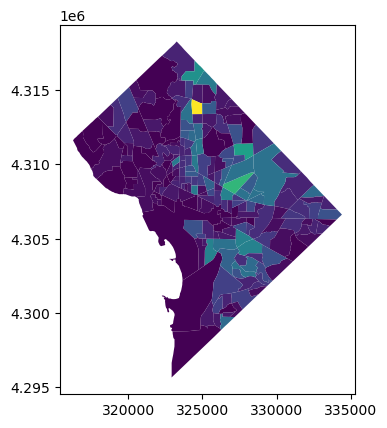

In [82]:
tracts_with_counts_gdf.plot(column='projects')

In [83]:
# Calculate projects per population
tracts_with_counts_gdf['projects_per_population'] = tracts_with_counts_gdf['projects'] / tracts_with_counts_gdf['population']

<Axes: >

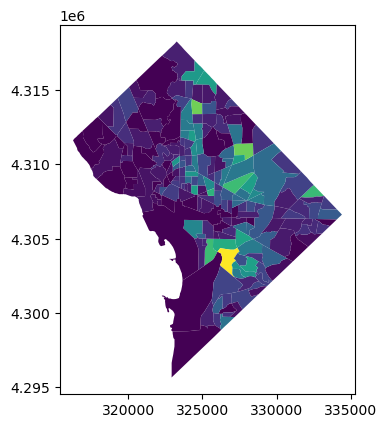

In [84]:
tracts_with_counts_gdf.plot(column='projects_per_population')

### How many units are in each census tract?

In [ ]:
# Use a the general 'agg' method to aggregate multiple columns at once by different methods
project_stats = tracts_with_projects_gdf.groupby('geoid').agg({
    'index_right': 'nunique',
    'TOTAL_AFFORDABLE_UNITS': 'sum',
})

tracts_with_counts_gdf = tracts_gdf.merge(project_stats, left_on='geoid', right_index=True)

columns = {
    'geoid':'geoid',
    'B01003001':'population',
    'index_right':'projects',
    'TOTAL_AFFORDABLE_UNITS': 'units',
    'geometry':'geometry',
}
tracts_with_counts_gdf = tracts_with_counts_gdf[columns.keys()].rename(columns=columns)

In [ ]:
tracts_with_counts_gdf.plot(column='units')